In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ompy as om
import logging
import pandas as pd
import json

import scipy as sp
#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter, LogFormatter)

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
om.__full_version__;
np.random.seed(1382398)

In [3]:
from ipynb.fs.full.functions import *

In [4]:
#setting figsize
plt.rcParams["figure.figsize"] = (8,6)

plt.rcParams["figure.autolayout"] = True

#size of errorbar caps
plt.rcParams["errorbar.capsize"] = 3

#setting label sizes
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12


#set linewidths and markersize
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.markersize'] = 7

#set x and y axis
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.top'] = True

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['legend.frameon'] = False

#setting different dpi for notebook and saving
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams["figure.dpi"] = 80

plt.rcParams['text.usetex'] = True

In [5]:
def set_size(width=390, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

Import $\gamma$SF and NLD from Oslo Method Software

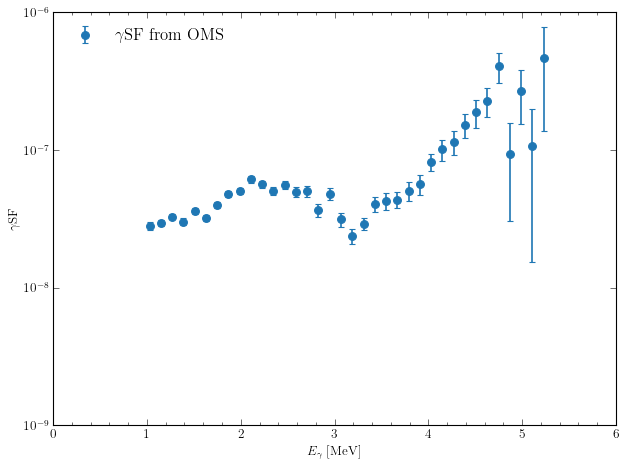

In [6]:
#reading files
def read_OMS(OMS_path):
    #OMS = Oslo Method Software
    #My normalization
    strength_nrm = np.genfromtxt(OMS_path+"strength.nrm") #experimental gamma strength function
    discrete_levels = np.genfromtxt(OMS_path+"rholev.cnt") #Discrete levels 
    rhopaw = np.genfromtxt(OMS_path+"rhopaw.cnt") #experimental level density
    fermigas = np.genfromtxt(OMS_path+"fermigas.cnt") #fermi gas extrapolation of nld
    trans_raw = np.genfromtxt(OMS_path+"transext.nrm") #gsf extrapolation
    fg_theo_file = OMS_path+'fgteo.rsg'
    fg_exp_file = OMS_path+'fg.rsg'
    fg_exp_err_file = OMS_path+'fgerr.rsg'
    
    #reading calibration constants from strength.cpp
    infile = open(OMS_path+'strength.cpp', 'r')
    for line in infile:
        values = line.split()
        if len(values)>1 and values[1]=='a0':
            a0 = float(values[3][:-1])
        if len(values)>1 and values[1]=='a1':
            a1 = float(values[3][:-1])
            break

    #splitting arrays into data and errors
    strength_nrm_split = np.array_split(strength_nrm,2)
    gsf_OMS = strength_nrm_split[0] 
    gsf_OMS_error = strength_nrm_split[1]

    rhopaw_split = np.array_split(rhopaw, 2)
    nld_OMS = rhopaw_split[0]
    nld_OMS_error = rhopaw_split[1]

    #variables for this experiment
    Sn = 5.762
    rhoSn = 28.07e6
    rhoSn_error = 7.02e6
    Eg_min = 999.9
    Eg_max = 5252

    #making energy array for gsf
    n_gsf = len(gsf_OMS)
    energy_gsf_OMS = np.zeros(n_gsf)
    for i in range(n_gsf):
        energy_gsf_OMS[i] = a0 + a1*i

    #making energy array for nld
    n_fermi = len(fermigas)
    energy_nld_OMS = np.zeros(n_fermi)
    for i in range(n_fermi):
        energy_nld_OMS[i] = a0 + a1*i

    #finding cutting index for plotting CT extrapolation
    n0_CT = np.argmin(abs(energy_nld_OMS-3.0))
    n1_CT = np.argmin(abs(energy_nld_OMS-Sn-0.5))

    n_trans_raw=len(trans_raw)
    gsf_extrapolation=np.zeros(n_trans_raw)
    energy_gsf_extrapolation=np.zeros(n_trans_raw)
    for i in range(n_trans_raw):
        energy_gsf_extrapolation[i] = a0 + a1*i
        gsf_extrapolation[i] = trans_raw[i]/(2*3.14*energy_gsf_extrapolation[i]**3)


    gsf_values = [energy_gsf_OMS, gsf_OMS, gsf_OMS_error]
    nld_values = [energy_nld_OMS, nld_OMS, nld_OMS_error, discrete_levels, fermigas, rhoSn, rhoSn_error, Sn, n0_CT, n1_CT]
    return gsf_values, nld_values

gsf_values = read_OMS('analysis/OMS/120keVperBin/')[0]

energy_gsf_OMS = gsf_values[0]
gsf_OMS = gsf_values[1]
gsf_OMS_error = gsf_values[2]

fig, ax = plt.subplots()

#OMS-analysis
ax.errorbar(x=energy_gsf_OMS, y=gsf_OMS, yerr=gsf_OMS_error, marker='o', linestyle='', label=' $\gamma$SF from OMS')
ax.set_ylim(1e-9, 1e-6)
ax.set_xlim(0, 6)
ax.set_yscale('log')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('$E_\gamma$  [MeV]')
ax.set_ylabel('$\gamma$SF')
ax.legend(fontsize=15)

fig.show()


In [7]:
#datetimes = ['02-04_17:11:09', '02-04_22:42:51', '02-04_15:39:51', '02-08_09:57:20']
#datetimes = ['02-22_17:36:16', '02-23_10:02:57', '02-23_13:03:23']
#datetimes = ['02-23_13:03:23', '02-23_14:08:46', '02-23_14:54:21']
#datetimes = ['02-23_13:03:23', '02-23_14:08:46', '02-26_15:59:51']
#datetimes = ['02-23_13:03:23', '02-23_14:08:46']
#datetimes = ['03-01_11:35:59', '03-01_13:07:47']
#datetimes = ['03-01_11:35:59', '03-02_11:19:18'] #dette er dataene jeg har brukt til alle figurer til nå
datetimes = ['04-26_09:12:21', '04-26_10:06:05']
#datetimes = ['04-26_09:12:21', '04-26_16:40:19'] #same, high gsf extrapolation area
#OMS_paths = ['analysis/OMS/120keVperBin/', 'analysis/OMS/180keVperBin/', 'analysis/OMS/240keVperBin/']
OMS_paths = ['analysis/OMS/120keVperBin/', 'analysis/OMS/185keVperBin/']

Import $\gamma$SF and NLD from OMPy

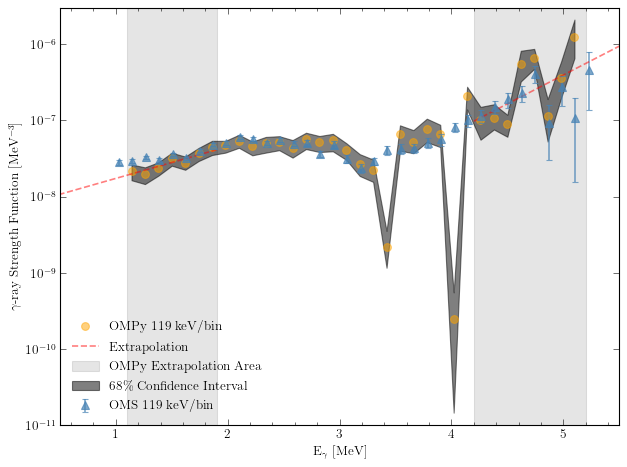

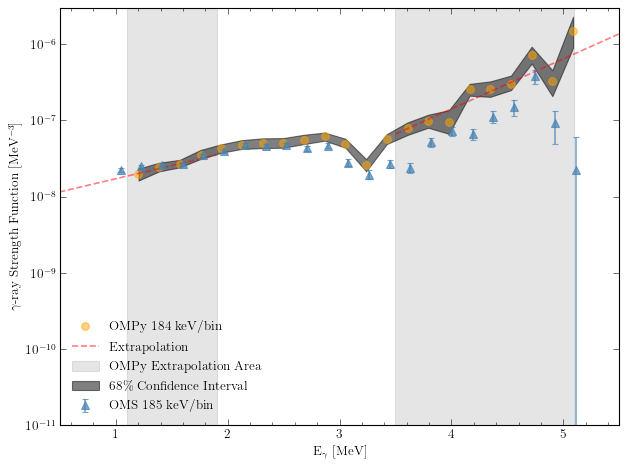

In [8]:
def plot_gsf_OMPy_vs_OMS(datetime, OMS_path, ax_gsf):
    #normalization areas for gsf
    path = 'analysis/OMPy/normalized_data/U233_2021-'+datetime
    
    infile = open(path+'/README.txt', 'r')
    gsf_norm = []
    for line in infile:
        if line.startswith('gSF'):
            values=line.split()
            gsf_norm.append(float(values[4]))
            gsf_norm.append(float(values[6]))
    gsfnorm_high = [gsf_norm[2], gsf_norm[3]]
    gsfnorm_low = [gsf_norm[0], gsf_norm[1]]
    
    infile.close()
    
    ax_gsf.fill_between(gsfnorm_low, [1,1], [0,0], color='black', alpha=0.1, label='OMPy Extrapolation Area')
    ax_gsf.fill_between(gsfnorm_high, [1,1], [0,0], color='black', alpha=0.1)
    
    [energy_gsf_OMS, gsf_OMS, gsf_OMS_error] = read_OMS(OMS_path)[0]
    [energy, median, error_upper, error_lower, error] = read_OMPy(datetime)[0]
    
    #make confidence interval plot
    ax_gsf.fill_between(energy, error_lower, error_upper, color='black', alpha=0.5, label='68\% Confidence Interval')
    ax_gsf.plot(energy, median, marker='o', linestyle='',  color='orange', label='OMPy %.0i keV/bin'%check_kevperbin(energy), alpha=.5)
    
    
    
    #plotting gsf extrapolations    
    for i in range(len(energy)):
        if energy[i]<gsf_norm[1]:
            low_cut_hi = i
        if energy[i]<gsf_norm[2]:
            hi_cut_low=i+1
        if energy[i]<gsf_norm[3]:
            hi_cut_hi = i
    
    z = np.polyfit(energy[hi_cut_low:hi_cut_hi], np.log(median[hi_cut_low:hi_cut_hi]), 1)
    fit = np.poly1d(z)
    energy_cont = np.linspace(gsf_norm[2], 10, 100)
    ax_gsf.plot(energy_cont, np.exp(fit(energy_cont)), '--', color='red', alpha=.5)
    
    z = np.polyfit(energy[:low_cut_hi], np.log(median[:low_cut_hi]), 1)
    fit = np.poly1d(z)
    energy_cont = np.linspace(-10, gsf_norm[1], 100)
    ax_gsf.plot(energy_cont, np.exp(fit(energy_cont)), '--', color='red', alpha=.5, label='Extrapolation')
    
    #plot settings
    ax_gsf.errorbar(x=energy_gsf_OMS, y=gsf_OMS, yerr=gsf_OMS_error, 
                marker='^', linestyle='', label='OMS %.0i keV/bin'%check_kevperbin(energy_gsf_OMS), color='steelblue', alpha=.7)
    
    ax_gsf.set_ylim(1e-11, 3e-6)
    ax_gsf.set_xlim(0.5, 5.5)
    ax_gsf.set_yscale('log')
    ax_gsf.yaxis.set_minor_locator(AutoMinorLocator())
    ax_gsf.xaxis.set_minor_locator(AutoMinorLocator())
    ax_gsf.set_xlabel('E$_\gamma$  [MeV]')
    ax_gsf.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')
    ax_gsf.legend(loc='lower left')
    
    
for i in range(len(datetimes)):
    datetime = datetimes[i]
    OMS_path = OMS_paths[i]
    fig, ax = plt.subplots()
    plot_gsf_OMPy_vs_OMS(datetime, OMS_path,ax)



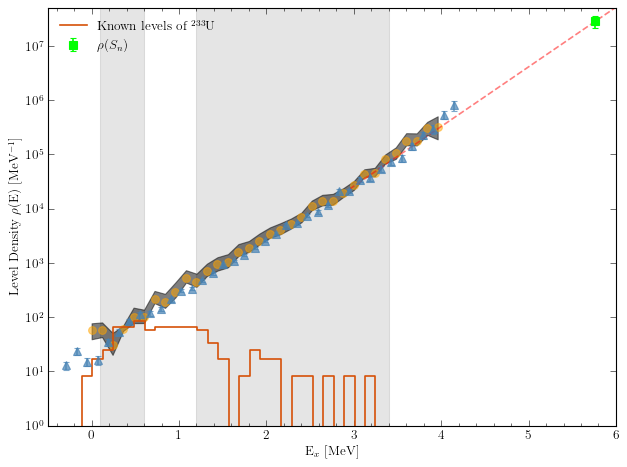

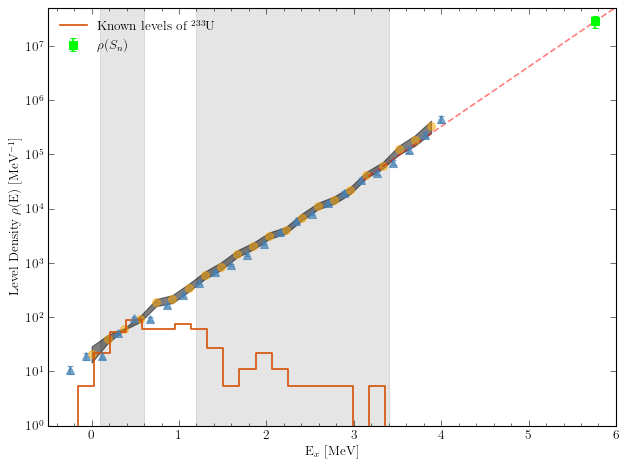

In [9]:
def plot_nld_OMPy_vs_OMS(datetime, OMS_path, ax_nld):
    
    #normalization areas for nld
    path = 'analysis/OMPy/normalized_data/U233_2021-'+datetime
    
    infile = open(path+'/README.txt', 'r')
    nld_norm = []
    for line in infile:
        if line.startswith('NLD'):
            values=line.split()
            nld_norm.append(float(values[4]))
            nld_norm.append(float(values[6]))
    
    nldnorm_high = [nld_norm[2], nld_norm[3]]
    nldnorm_low = [nld_norm[0], nld_norm[1]]
    
    infile.close()
    
    
    
    nldnorm_low = [0.1, 0.6]
    nldnorm_high = [1.2,3.4]
    
    ax_nld.fill_between(nldnorm_low, [1e8,1e8], [0,0], color='black', alpha=0.1)
    ax_nld.fill_between(nldnorm_high, [1e8,1e8], [0,0], color='black', alpha=0.1)
    
    [energy_nld_OMS, nld_OMS, nld_OMS_error, discrete_levels, fermigas, rhoSn, rhoSn_error, Sn, n0_CT, n1_CT] = read_OMS(OMS_path)[1]
    [energy, median, error_upper, error_lower, error] = read_OMPy(datetime)[1]
    
    #plotting OMS nld
    ax_nld.errorbar(x=energy_nld_OMS[:len(nld_OMS)], y=nld_OMS, yerr=nld_OMS_error, 
                marker='^', linestyle='', color='steelblue', alpha=.7)
        
    #plotting neutron separation energy
    ax_nld.errorbar(x=Sn, y=rhoSn, yerr=rhoSn_error, marker='s', linestyle='', label='$\\rho(S_n)$', color='lime')

    #plotting OMPy nld
    ax_nld.fill_between(energy, error_upper, error_lower, color='black', alpha=0.5)
    ax_nld.plot(energy, median, marker='o', linestyle='', color='orange', alpha=.5)

    
    #plotting CT extrapolation from OMS
    ax_nld.plot(energy_nld_OMS[n0_CT:n1_CT], fermigas[n0_CT:n1_CT], linestyle='--', color='red', alpha=.5)

    #plotting discrete levels
    ax_nld.step(energy_nld_OMS[:len(discrete_levels)], discrete_levels, color="#D65108", label='Known levels of $^{233}$U', where='mid')

    #NLD axis settings
    ax_nld.set_xlabel('E$_x$ [MeV]')
    ax_nld.set_ylabel('Level Density $\\rho$(E) [MeV$^{-1}$]')
    ax_nld.legend()
    ax_nld.set_yscale('log')
    ax_nld.yaxis.set_minor_locator(AutoMinorLocator())
    ax_nld.xaxis.set_minor_locator(AutoMinorLocator())
    ax_nld.set_ylim(1e0, 5e7)
    ax_nld.set_xlim(-.5, 6)
    

    
for i in range(len(datetimes)):
    datetime = datetimes[i]
    OMS_path = OMS_paths[i]
    fig, ax = plt.subplots()
    plot_nld_OMPy_vs_OMS(datetime, OMS_path,ax)


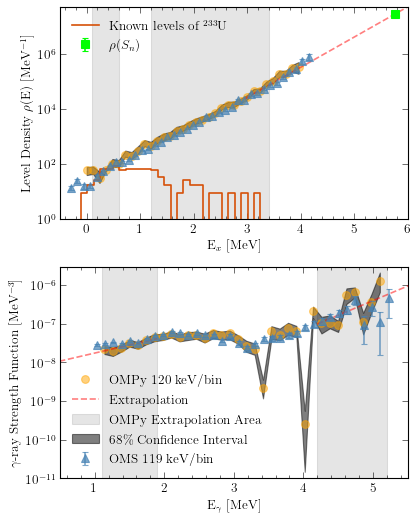

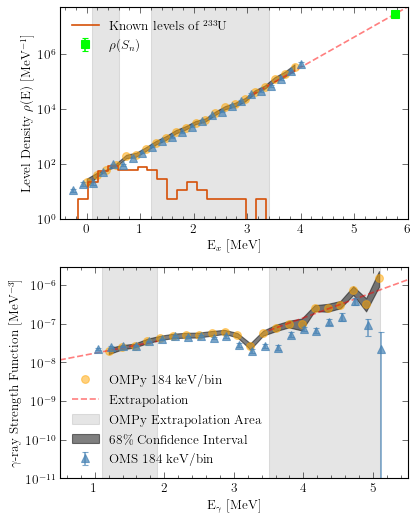

In [10]:
fignames= ['ompy_vs_oms_120kevperbin', 'ompy_vs_oms_185kevperbin']
def plot_OMPy_vs_OMS(datetime, OMS_path):
    fig = plt.figure(figsize = set_size(subplots=(2,1)))
    gs = gridspec.GridSpec(2, 1)
    ax_nld = plt.subplot(gs[0,0])
    ax_gsf = plt.subplot(gs[1,0])
    #ax3 = plt.subplot(gs[0:1,0])
    plot_nld_OMPy_vs_OMS(datetime, OMS_path, ax_nld)
    plot_gsf_OMPy_vs_OMS(datetime, OMS_path, ax_gsf)
    
    #h, l = ax_nld.get_legend_handles_labels()
    #ax3.set_yticks([])
    #ax3.set_xticks([])
    #ax3.axis('off')
    #ax3.legend(h, l, ncol=2, fontsize=10, frameon=True, facecolor='white', framealpha=.9, loc='center')
    fig.subplots_adjust(bottom=0.2)
    fig.savefig(fignames[i])
    

for i in range(len(datetimes)):
    datetime = datetimes[i]
    OMS_path = OMS_paths[i]
    plot_OMPy_vs_OMS(datetime, OMS_path)
